# cygnus-reward-timely

Vary Cygnus rewards for acccurate-late and accurate-timely prefetches.

3/25/2024

In [1]:
import os
from pathlib import Path
import sys
from typing import Optional

from matplotlib.cm import get_cmap
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../../../"))
from naboo_utils.file import ChampsimStudy
from naboo_utils.table import ChampsimTabler

In [2]:
# ~~~ Configuration ~~~
sim_dir             : Path = Path("/u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/")
sim_dir_3200        : Path = sim_dir / "default_3200"
sim_dir_200         : Path = sim_dir / "default_200"
baseline_study      : str  = "baseline"
baseline_experiment : str  = "_baseline"

naboo_dir      : Path = Path("/u/cmolder/GitHub/ChampSim-2022/external/naboo/")
suite_file     : Path = naboo_dir / "conf" / "suites.toml"
benchmark_file : Path = naboo_dir / "conf" / "benchmarks.toml"
mix_file       : Path = naboo_dir / "conf" / "mixes.toml"
mix_set        : str  = "1core_tune"
num_threads    : int  = 24

# ~~~ Study ~~~
study_3200   : ChampsimStudy = ChampsimStudy.from_study_dir(sim_dir_3200 / "cygnus_reward_timely")
study_3200_b : ChampsimStudy = ChampsimStudy.from_study_dir(sim_dir_3200 / "baseline")
study_200    : ChampsimStudy = ChampsimStudy.from_study_dir(sim_dir_200 / "cygnus_reward_timely")
study_200_b  : ChampsimStudy = ChampsimStudy.from_study_dir(sim_dir_200 / "baseline")

# ~~~ Plotting ~~~
dpi = 192
Path("cygnus_reward_timely").mkdir(exist_ok=True)

In [3]:
study_3200.read_all(
    baseline_study=study_3200_b,
    baseline_exp=baseline_experiment, 
    num_threads=num_threads
)
study_200.read_all(
    baseline_study=study_200_b,
    baseline_exp=baseline_experiment, 
    num_threads=num_threads
)

[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 3492/3492 [00:43<00:00, 79.83file/s] 
[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 3492/3492 [00:42<00:00, 82.91file/s] 


In [4]:
tabler_3200 = ChampsimTabler(
    study_3200, suite_file, benchmark_file, mix_file, mix_set, 
    num_threads=num_threads
)
tabler_200 = ChampsimTabler(
    study_200, suite_file, benchmark_file, mix_file, mix_set,
    num_threads=num_threads
)

[ipykernel_launcher][angrist-3] Collating files: 100%|██████████| 3492/3492 [00:09<00:00, 350.99file/s]


# Helper functions

In [5]:
def get_stat_df(tabler: ChampsimTabler,
                statistic: str, 
                level: str = "overall",
                suite: Optional[str] = None, 
                benchmark: Optional[str] = None) -> pd.DataFrame:
    suite_ = {suite} if suite else set()
    benchmark_ = {benchmark} if benchmark else set()
    stat_key : str = ""

    if level == "overall":
        stat_df : pd.DataFrame = tabler.table_statistic_overall(
            statistic, suites=suite_, benchmarks=benchmark_
        ).df
        stat_key = stat_df.columns[0]
    elif level == "suite":
        assert(suite)
        stat_df : pd.DataFrame = tabler.table_statistic_suite(
            statistic, suites=list(suite_), benchmarks=benchmark_
        ).df
        stat_df = stat_df[suite].to_frame()
        stat_key = suite
    elif level == "benchmark":
        assert(benchmark)
        stat_df : pd.DataFrame = tabler.table_statistic_benchmark(
            statistic, suites=suite_, benchmarks=list(benchmark_)
        ).df
        stat_df = stat_df[benchmark].to_frame()
        stat_key = benchmark
    else:
        raise ValueError(f"Invalid level: {level}")

    stat_df = stat_df[[stat_df.columns[0]]]

    # Add Rat, Ral columns
    stat_df["Rat"] = stat_df.index.str.split("__").str[1].str.split("_").str[1].astype(int)
    stat_df["Ral"] = stat_df.index.str.split("__").str[2].str.split("_").str[1].astype(int)

    stat_df = stat_df[["Rat", "Ral", stat_key]].reset_index(drop=True)
    stat_df = stat_df.sort_values(["Rat", "Ral"])

    return stat_df

def plot_heatmap(tabler: ChampsimTabler, statistic: str,
                 secondary_statistic: Optional[str] = None,
                 title: str = "", 
                 level = "overall",
                 suite     : Optional[str] = None,
                 benchmark : Optional[str] = None,
                 cmap      : str = "Blues"):
    
    stat_df           : pd.DataFrame = get_stat_df(
        tabler, statistic, 
        level=level, suite=suite, benchmark=benchmark
    )
    stat_df_secondary : Optional[pd.DataFrame] = get_stat_df(
        tabler, secondary_statistic, 
        level=level, suite=suite, benchmark=benchmark
    ) if secondary_statistic else None

    # Plot x-axis : Rat
    #      y-axis : Ral
    #      color  : gmean

    # Get array
    n_rat = len(stat_df["Rat"].unique())
    n_ral = len(stat_df["Ral"].unique())
    v_rat = stat_df["Rat"].unique()
    v_ral = stat_df["Ral"].unique()

    image           : np.ndarray           = np.nan * np.zeros((n_rat, n_ral))
    image_secondary : Optional[np.ndarray] = None
    for i, row in stat_df.iterrows():
        image_x = np.where(v_rat == row["Rat"])[0][0]
        image_y = np.where(v_ral == row["Ral"])[0][0]
        image[image_x, image_y] = row.iloc[-1]

    if stat_df_secondary is not None:
        image_secondary = np.nan * np.zeros((n_rat, n_ral))
        for i, row in stat_df_secondary.iterrows():
            image_x = np.where(v_rat == row["Rat"])[0][0]
            image_y = np.where(v_ral == row["Ral"])[0][0]
            image_secondary[image_x, image_y] = row.iloc[-1]
    
    value_min, value_max = np.nanmin(image), np.nanmax(image)
    image_norm = (image - value_min) / (value_max - value_min)
    
    cmap = get_cmap(cmap)
    fig, ax = plt.subplots()
    im = ax.imshow(image, cmap=cmap, vmin=value_min, vmax=value_max)

    ax.set_xticks(np.arange(n_ral))
    ax.set_yticks(np.arange(n_rat))
    ax.set_xticklabels(v_ral)
    ax.set_yticklabels(v_rat)
    ax.set_xlabel("$R_{AL}$")
    ax.set_ylabel("$R_{AT}$")
    ax.set_title(title)

    # Annotate
    for i, j in np.ndindex(image.shape):
        value = image[i, j]
        value_norm = image_norm[i, j]
        if np.isnan(value):
            continue

        # color = "k" if value_norm > 0.5 else "w"
        color    : str = "w" if value_norm > 0.5 else "k"
        fontsize : int = 10

        if isinstance(image_secondary, np.ndarray):
            value_secondary = image_secondary[i, j]
            ax.text( # Primary stat
                j, i - 0.15, f"{value:.2f}", 
                color=color, ha="center", va="center", 
                fontsize=fontsize
            )
            ax.text( # Secondary stat
                j, i + 0.3, f"({value_secondary:.2f})", 
                color=color, ha="center", va="bottom", 
                fontsize=fontsize - 1
            )
        else:
            ax.text( # Primay stat
                j, i, f"{value:.2f}", 
                color=color, ha="center", va="center", 
                fontsize=fontsize
            )

    # Draw red box around original configuration (R_AT = 20, R_AL = 12)
    rectangle = patches.Rectangle((2.5, 4.5), 1, 1, ec="red",fc="none", zorder=100)
    ax.add_patch(rectangle)

    # Draw black boxes around each configuration where R_AT = R_AL
    for i in range(n_ral):
        rectangle = patches.Rectangle((i - 0.5, i - 0.5), 1, 1, ec="yellow", fc="none", zorder=100)
        ax.add_patch(rectangle)


# 3200 MT/s

## Heatmaps

### IPC improvement

#### Overall

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


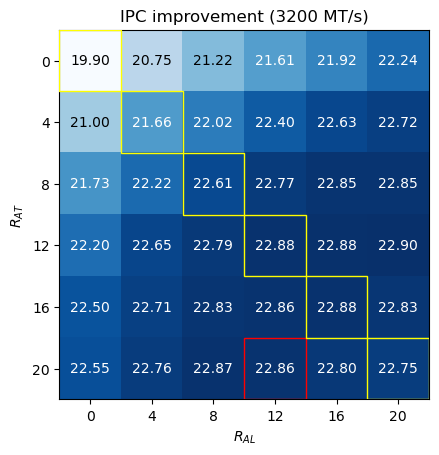

In [6]:
plot_heatmap(tabler_3200, "cpu.gmean.ipc_improvement",
             title="IPC improvement (3200 MT/s)",
             level="overall")
plt.savefig(Path("cygnus_reward_timely") / "ipc_improvement__3200.png", bbox_inches="tight", dpi=dpi)

#### spec06

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


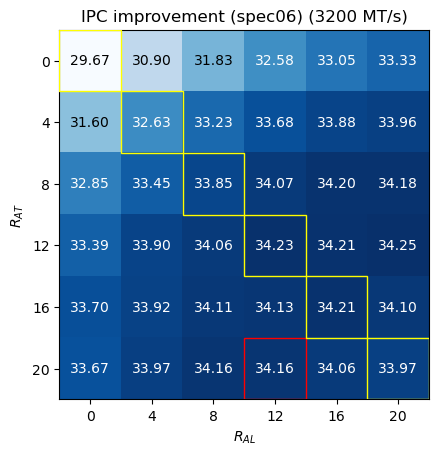

In [7]:
suite = "spec06"
plot_heatmap(tabler_3200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (3200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### spec17

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


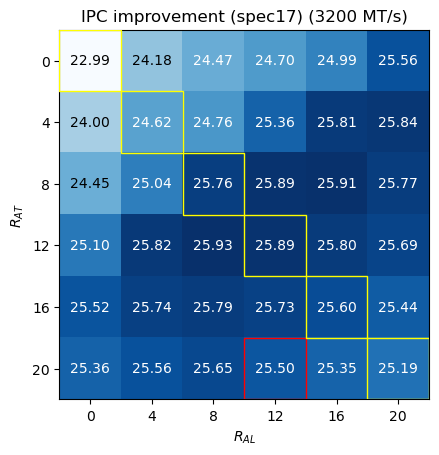

In [8]:
suite = "spec17"
plot_heatmap(tabler_3200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (3200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### cloudsuite

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


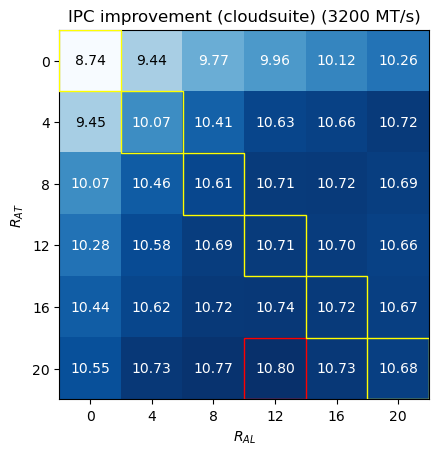

In [9]:
suite = "cloudsuite"
plot_heatmap(tabler_3200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (3200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### gap

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


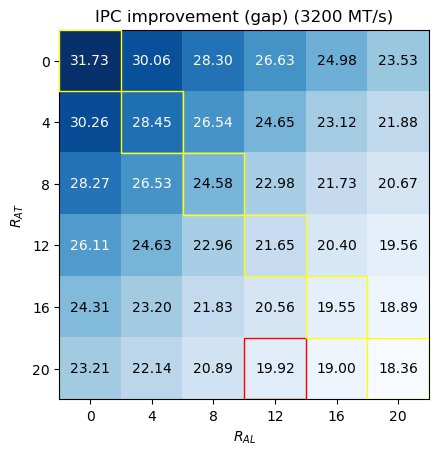

In [10]:
suite = "gap"
plot_heatmap(tabler_200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (3200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

### Prefetch accuracy

#### overall

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


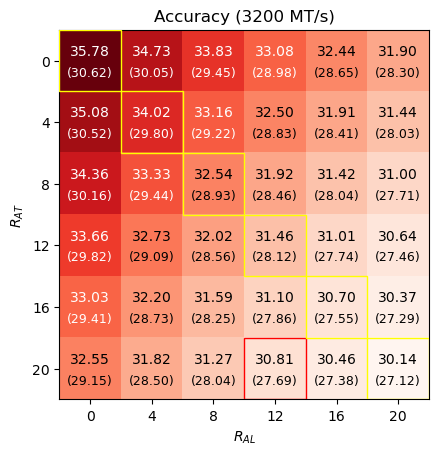

In [11]:
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title="Accuracy (3200 MT/s)",
             level="overall", cmap="Reds")
plt.savefig(Path("cygnus_reward_timely") / "accuracy__3200.png", bbox_inches="tight", dpi=dpi)

#### spec06

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


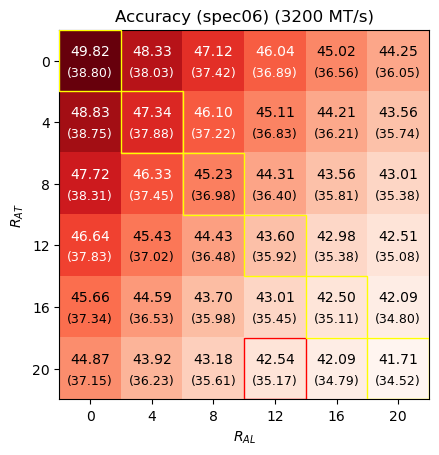

In [12]:
suite = "spec06"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic="cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### spec17

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


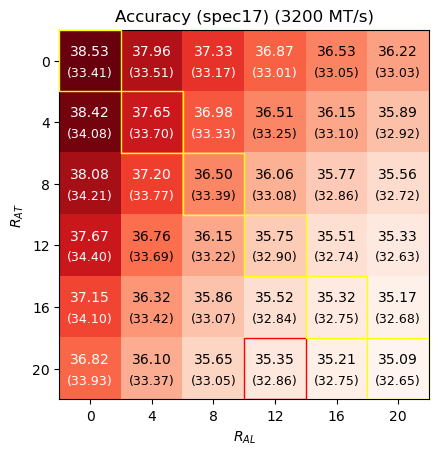

In [13]:
suite = "spec17"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### cloudsuite

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


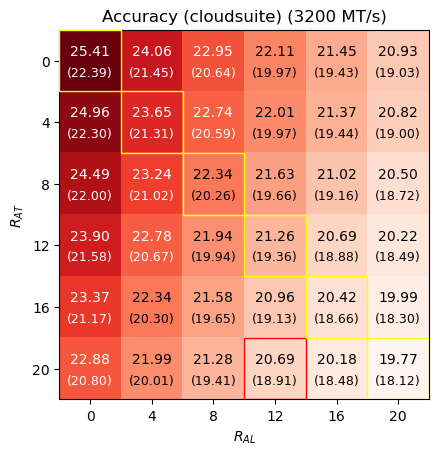

In [14]:
suite = "cloudsuite"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### gap

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


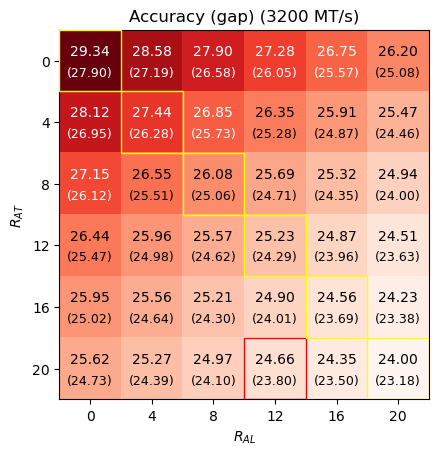

In [15]:
suite = "gap"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

### Prefetch coverage

#### overall

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


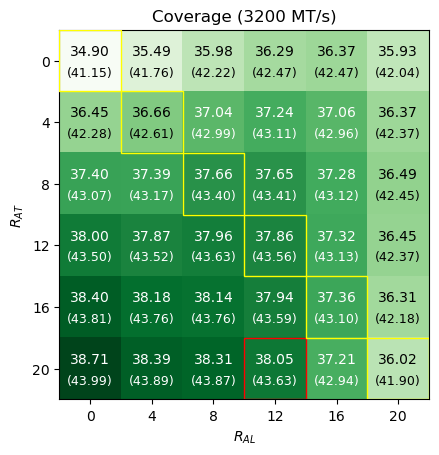

In [16]:
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title="Coverage (3200 MT/s)",
             level="overall", cmap="Greens")
plt.savefig(Path("cygnus_reward_timely") / "coverage__3200.png", bbox_inches="tight", dpi=dpi)

#### spec06

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


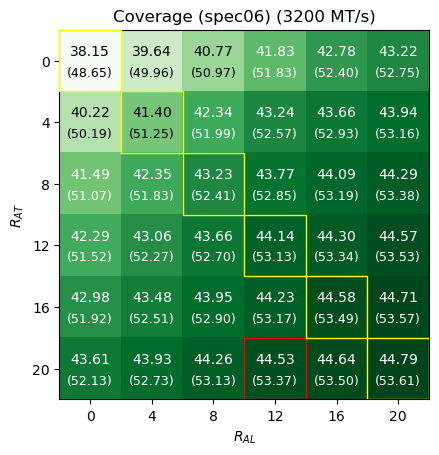

In [17]:
suite = "spec06"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title=f"Coverage ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### spec17

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


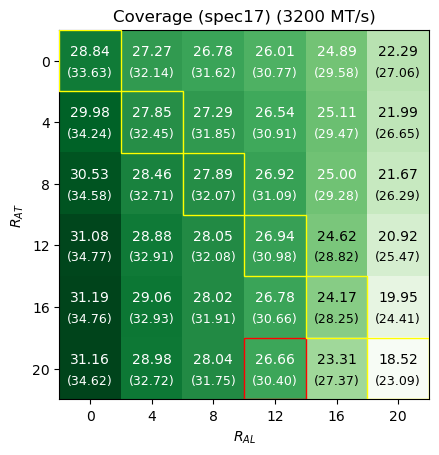

In [18]:
suite = "spec17"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title=f"Coverage ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### cloudsuite

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


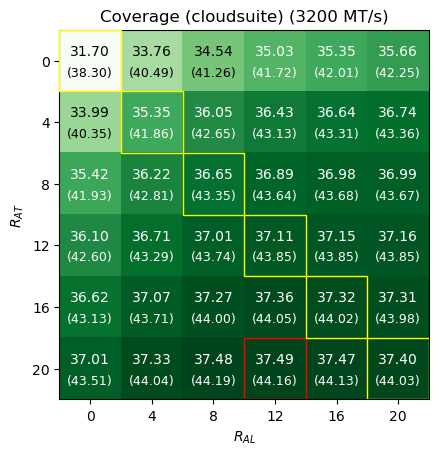

In [19]:
suite = "cloudsuite"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title=f"Coverage ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### gap

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


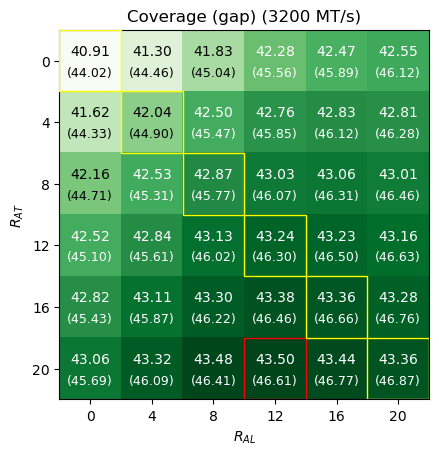

In [20]:
suite = "gap"
plot_heatmap(tabler_3200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title=f"Coverage ({suite}) (3200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__3200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

# 200 MT/s

## Heatmaps

### IPC improvement

#### Overall

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


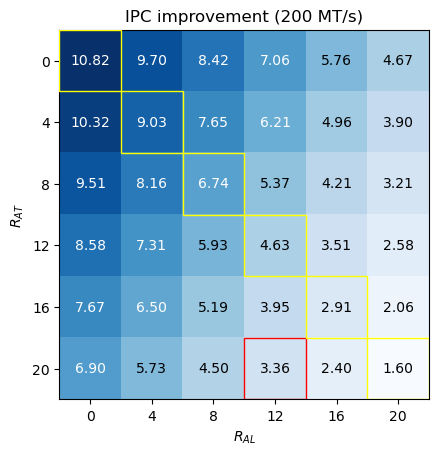

In [21]:
plot_heatmap(tabler_200, "cpu.gmean.ipc_improvement",
             title="IPC improvement (200 MT/s)",
             level="overall")
plt.savefig(Path("cygnus_reward_timely") / "ipc_improvement__200.png", bbox_inches="tight", dpi=dpi)

#### spec06

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


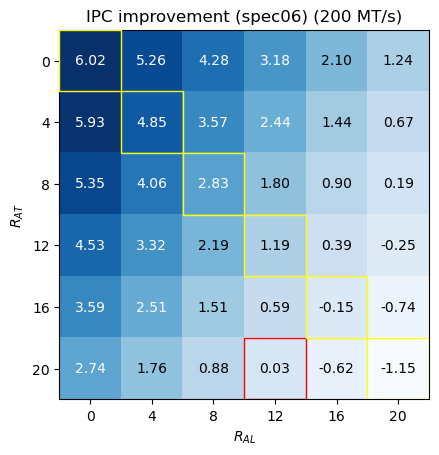

In [22]:
suite = "spec06"
plot_heatmap(tabler_200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### spec17

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


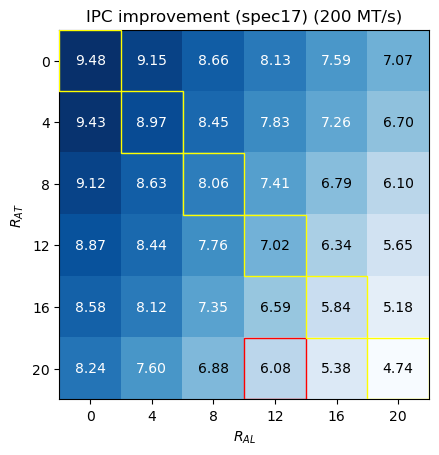

In [23]:
suite = "spec17"
plot_heatmap(tabler_200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### cloudsuite

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


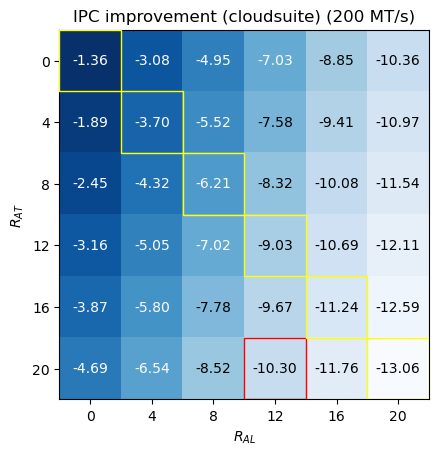

In [24]:
suite = "cloudsuite"
plot_heatmap(tabler_200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### gap

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


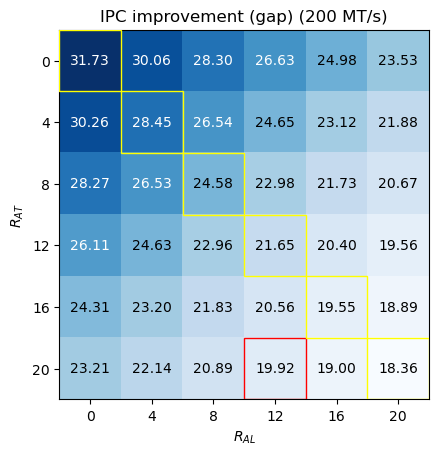

In [25]:
suite = "gap"
plot_heatmap(tabler_200, "cpu.gmean.ipc_improvement",
             title=f"IPC improvement ({suite}) (200 MT/s)",
             level="suite", suite=suite)
plt.savefig(
    Path("cygnus_reward_timely") / f"ipc_improvement__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

### Prefetch accuracy

#### overall

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


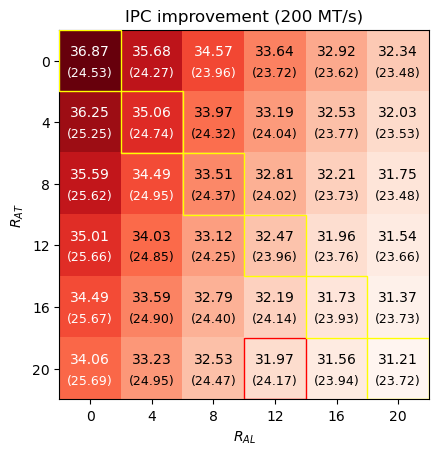

In [26]:
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title="IPC improvement (200 MT/s)",
             level="overall", cmap="Reds")
plt.savefig(Path("cygnus_reward_timely") / "accuracy__200.png", bbox_inches="tight", dpi=dpi)

#### spec06

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


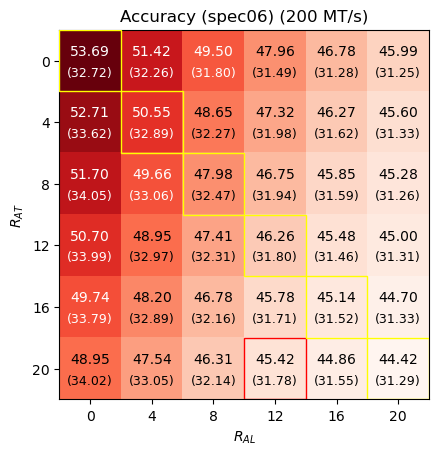

In [27]:
suite = "spec06"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### spec17

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


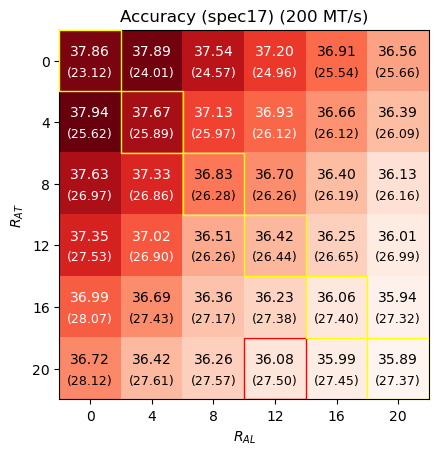

In [28]:
suite = "spec17"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### cloudsuite

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


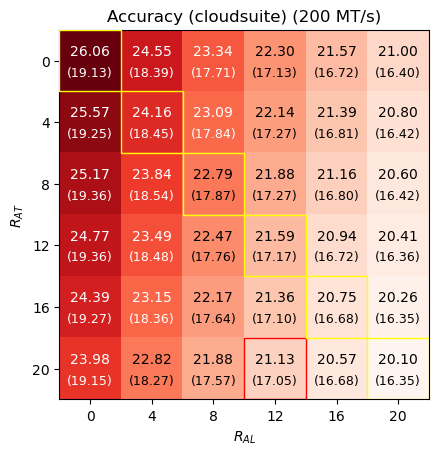

In [29]:
suite = "cloudsuite"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### gap

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


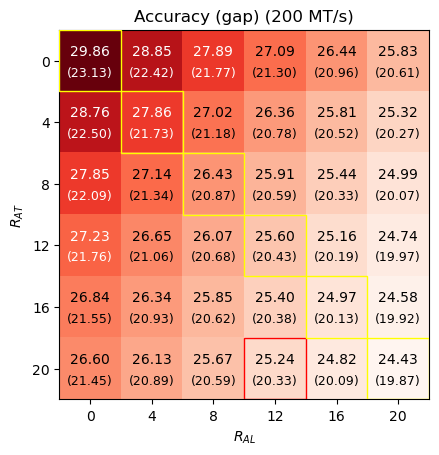

In [30]:
suite = "gap"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_accuracy",
             secondary_statistic = "cache.L2C.amean.prefetch_accuracy_timely",
             title=f"Accuracy ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Reds")
plt.savefig(
    Path("cygnus_reward_timely") / f"accuracy__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

### Prefetch coverage

#### overall

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


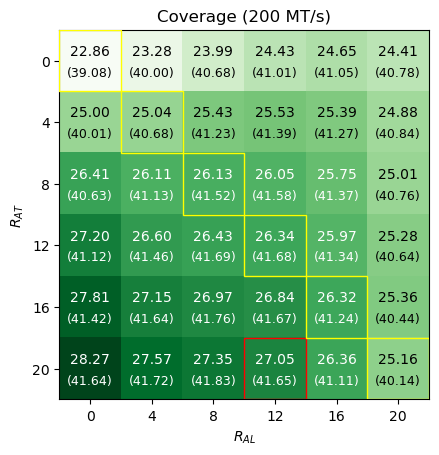

In [31]:
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title="Coverage (200 MT/s)",
             level="overall", cmap="Greens")
plt.savefig(Path("cygnus_reward_timely") / "coverage__200.png", bbox_inches="tight", dpi=dpi)

#### spec06

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


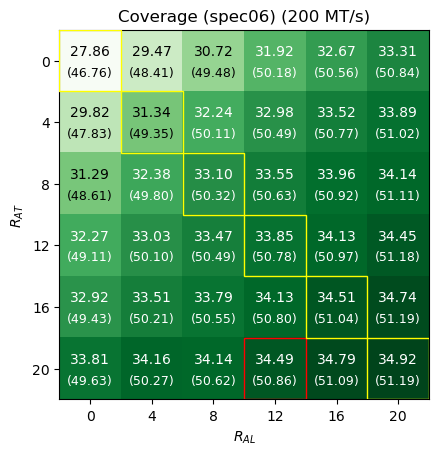

In [32]:
suite = "spec06"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title=f"Coverage ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### spec17

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


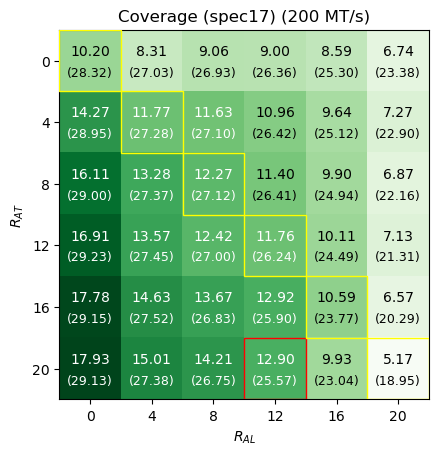

In [33]:
suite = "spec17"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_coverage",
             secondary_statistic = "cache.L2C.amean.prefetch_coverage_untimely",
             title=f"Coverage ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### cloudsuite

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


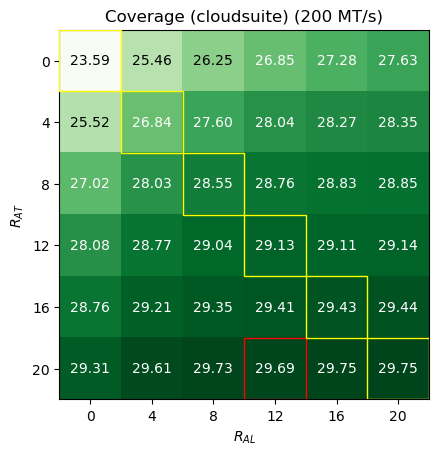

In [34]:
suite = "cloudsuite"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_coverage",
             title=f"Coverage ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)

#### gap

/tmp/ipykernel_565390/1942824230.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


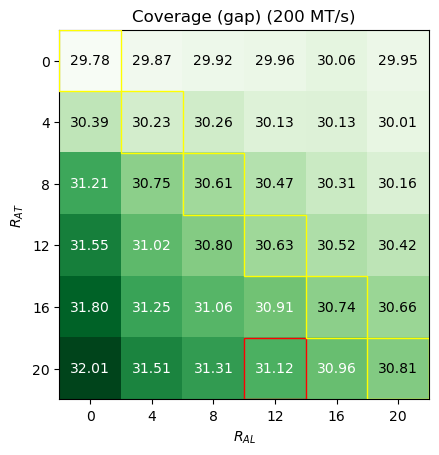

In [35]:
suite = "gap"
plot_heatmap(tabler_200, "cache.L2C.amean.prefetch_coverage",
             title=f"Coverage ({suite}) (200 MT/s)",
             level="suite", suite=suite, cmap="Greens")
plt.savefig(
    Path("cygnus_reward_timely") / f"coverage__200__{suite}.png", 
    bbox_inches="tight", dpi=dpi
)